# Question 3

## Question 3.1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('eduNext.csv')

In [4]:
df.head()

,Unnamed: 0,TradeDate,StartPrice,EndPrice,PeakPrice,BottomPrice,TradedVolume
0,0,2020-01-02,120.154671,120.163195,118.596210,119.047566,NaN
1,1,2020-01-03,118.569069,119.331874,117.489147,117.849121,NaN
2,2,2020-01-06,118.474808,118.509098,116.992055,117.043478,NaN
3,3,2020-01-07,116.460686,118.157710,116.409263,117.660599,NaN
4,4,2020-01-08,117.369179,117.917712,116.220688,116.306389,NaN


In [5]:
df['TradeDate'] = pd.to_datetime(df['TradeDate'])
df.set_index('TradeDate', inplace=True)

In [6]:
df.head()

,Unnamed: 0,StartPrice,EndPrice,PeakPrice,BottomPrice,TradedVolume
TradeDate,,,,,,
2020-01-02,0,120.154671,120.163195,118.596210,119.047566,NaN
2020-01-03,1,118.569069,119.331874,117.489147,117.849121,NaN
2020-01-06,2,118.474808,118.509098,116.992055,117.043478,NaN
2020-01-07,3,116.460686,118.157710,116.409263,117.660599,NaN
2020-01-08,4,117.369179,117.917712,116.220688,116.306389,NaN


In [7]:
# ADF Test
adf_result = adfuller(df['EndPrice'])
print("ADF Test Statistic:", adf_result[0])
print("ADF p-value:", adf_result[1])
print("ADF Critical Values:", adf_result[4])
if adf_result[1] > 0.05:
    print("Fail to reject H0 → Likely a Random Walk (non-stationary)")
else:
    print("Reject H0 → Stationary (not a random walk)")

ADF Test Statistic: 0.9306079303040308
ADF p-value: 0.9934770455822314
ADF Critical Values: {'1%': np.float64(-3.4350837211576697), '5%': np.float64(-2.863630592595516), '10%': np.float64(-2.5678830271851716)}
Fail to reject H0 → Likely a Random Walk (non-stationary)


In [9]:
# KPSS Test
from statsmodels.tsa.stattools import  kpss

kpss_result = kpss(df['EndPrice'], regression='c')
print("\nKPSS Test Statistic:", kpss_result[0])
print("KPSS p-value:", kpss_result[1])
print("KPSS Critical Values:", kpss_result[3])
if kpss_result[1] < 0.05:
    print("Reject H0 → Non-stationary")
else:
    print("Fail to reject H0 → Stationary")


KPSS Test Statistic: 4.596176383894512
KPSS p-value: 0.01
KPSS Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Reject H0 → Non-stationary


In [10]:
df['EndPrice_diff'] = df['EndPrice'].diff().dropna()

In [11]:
df['EndPrice_logdiff'] = df['EndPrice'].apply(np.log).diff().dropna()

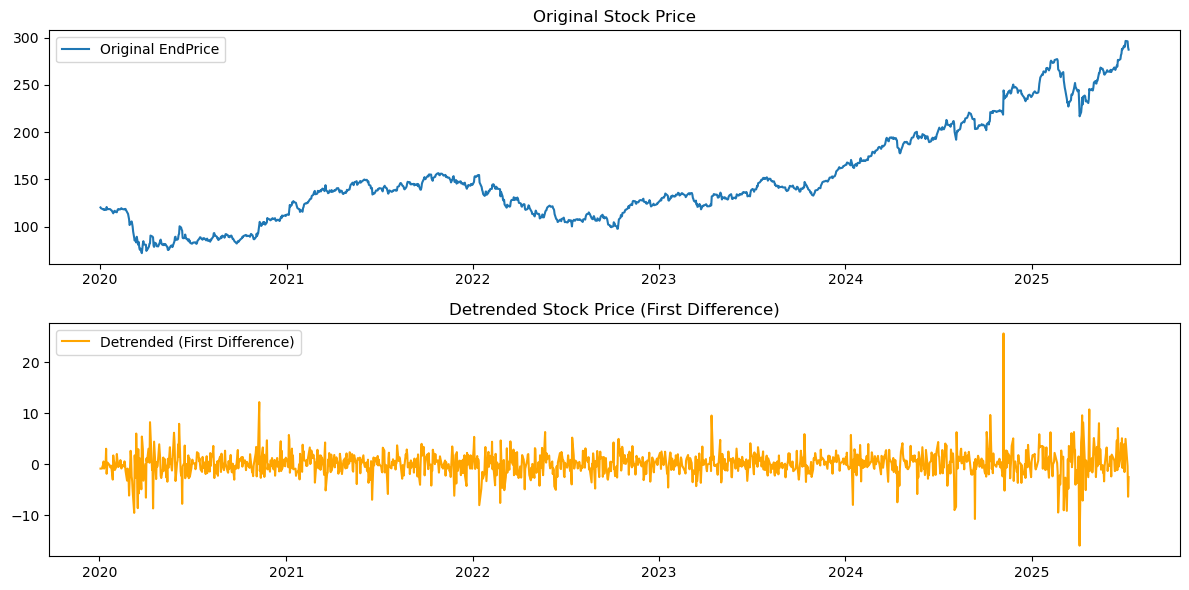

In [12]:
# Plot original vs differenced
plt.figure(figsize=(12,6))

plt.subplot(2,1,1)
plt.plot(df['EndPrice'], label="Original EndPrice")
plt.title("Original Stock Price")
plt.legend()

plt.subplot(2,1,2)
plt.plot(df['EndPrice_diff'], label="Detrended (First Difference)", color="orange")
plt.title("Detrended Stock Price (First Difference)")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# ADF Test on differenced series
adf_result = adfuller(df['EndPrice_diff'].dropna())
print("ADF p-value (differenced):", adf_result[1])

# KPSS Test on differenced series
kpss_result = kpss(df['EndPrice_diff'].dropna(), regression='c')
print("KPSS p-value (differenced):", kpss_result[1])

ADF p-value (differenced): 0.0
KPSS p-value (differenced): 0.06385320930166224


In [14]:
from statsmodels.stats.diagnostic import het_arch

# Drop missing values from differenced series
returns = df['EndPrice_diff'].dropna()

# ARCH LM Test
arch_test = het_arch(returns)
print("LM Stat:", arch_test[0])
print("LM p-value:", arch_test[1])


LM Stat: 22.827420478173295
LM p-value: 0.011401838478365095


In [15]:
from arch import arch_model

# Series must have no NaNs
returns = df['EndPrice_diff'].dropna()

# ARCH(1)
arch1 = arch_model(returns, vol='ARCH', p=1)
res_arch1 = arch1.fit(disp='off')
print("\nARCH(1) Model Summary:")
print(res_arch1.summary())

# ARCH(2)
arch2 = arch_model(returns, vol='ARCH', p=2)
res_arch2 = arch2.fit(disp='off')
print("\nARCH(2) Model Summary:")
print(res_arch2.summary())



ARCH(1) Model Summary:
                      Constant Mean - ARCH Model Results                      
Dep. Variable:          EndPrice_diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3153.43
Distribution:                  Normal   AIC:                           6312.86
Method:            Maximum Likelihood   BIC:                           6328.56
                                        No. Observations:                 1385
Date:                Fri, Oct 03 2025   Df Residuals:                     1384
Time:                        10:50:17   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1749  8.034e-02      2.

In [16]:
from arch import arch_model

# Make sure returns are stationary (your differenced series)
returns = df['EndPrice_diff'].dropna()

# Fit GARCH(1,1)
garch11 = arch_model(returns, vol='GARCH', p=1, q=1)
res_garch11 = garch11.fit(disp='off')

print(res_garch11.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:          EndPrice_diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3110.23
Distribution:                  Normal   AIC:                           6228.47
Method:            Maximum Likelihood   BIC:                           6249.40
                                        No. Observations:                 1385
Date:                Fri, Oct 03 2025   Df Residuals:                     1384
Time:                        10:51:18   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1286  5.920e-02      2.171  2.990e-02 [1.252e-0

In [17]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

models = {
    "ARCH(1)": res_arch1,
    "ARCH(2)": res_arch2,
    "GARCH(1,1)": res_garch11
}

for name, model in models.items():
    print(f"\n--- Diagnostics for {name} ---")
    
    # Get residuals
    resid = model.resid.dropna()
    
    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(resid, lags=[10], return_df=True)
    print("Ljung-Box (resid):", lb_resid)
    
    # Ljung-Box on squared residuals
    lb_resid2 = acorr_ljungbox(resid**2, lags=[10], return_df=True)
    print("Ljung-Box (squared resid):", lb_resid2)
    
    # Engle's ARCH test
    arch_test = het_arch(resid)
    print("ARCH LM Test Stat:", arch_test[0])
    print("ARCH LM p-value:", arch_test[1])



--- Diagnostics for ARCH(1) ---
      lb_stat  lb_pvalue
10  14.727214   0.142328
Ljung-Box (squared resid):       lb_stat  lb_pvalue
10  33.066559   0.000265
ARCH LM Test Stat: 24.63087751684069
ARCH LM p-value: 0.006090855074475804

--- Diagnostics for ARCH(2) ---
Ljung-Box (resid):       lb_stat  lb_pvalue
10  14.727214   0.142328
Ljung-Box (squared resid):       lb_stat  lb_pvalue
10  33.389029   0.000234
ARCH LM Test Stat: 24.857422509862477
ARCH LM p-value: 0.005622408847115261

--- Diagnostics for GARCH(1,1) ---
Ljung-Box (resid):       lb_stat  lb_pvalue
10  14.727214   0.142328
Ljung-Box (squared resid):       lb_stat  lb_pvalue
10  32.374291   0.000347
ARCH LM Test Stat: 24.145532426771187
ARCH LM p-value: 0.007223332954110354


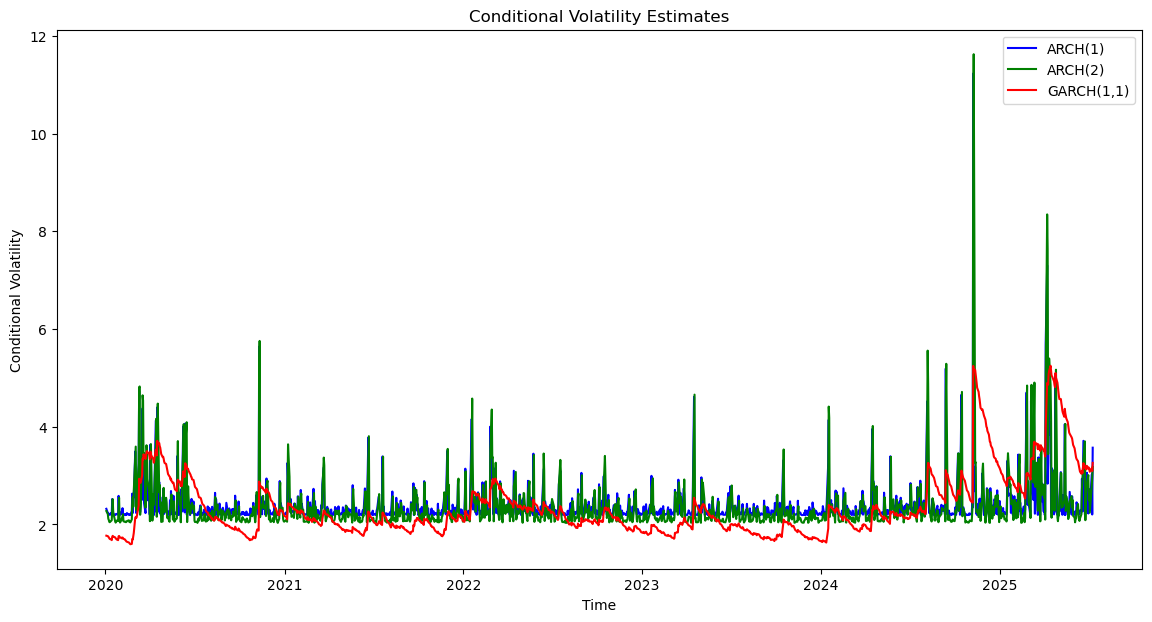

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

# ARCH(1)
plt.plot(res_arch1.conditional_volatility, label="ARCH(1)", color="blue")

# ARCH(2)
plt.plot(res_arch2.conditional_volatility, label="ARCH(2)", color="green")

# GARCH(1,1)
plt.plot(res_garch11.conditional_volatility, label="GARCH(1,1)", color="red")

plt.title("Conditional Volatility Estimates")
plt.xlabel("Time")
plt.ylabel("Conditional Volatility")
plt.legend()
plt.show()




##  1. Residual Autocorrelation (Ljung-Box on Residuals)

* **ARCH(1), ARCH(2), GARCH(1,1):**
  p-value ≈ 0.14 (> 0.05) → No significant autocorrelation left in the residuals.
   All models capture the **mean dynamics** well.

##  2. Volatility Dynamics (Ljung-Box on Squared Residuals)

* **ARCH(1), ARCH(2), GARCH(1,1):**
  All p-values < 0.05 → **squared residuals are still autocorrelated**, meaning volatility clustering hasn’t been fully captured.

This shows the models reduce volatility clustering but don’t eliminate it entirely (very common).



##  3. Engle’s ARCH LM Test

* **ARCH(1):** p ≈ 0.006 → ARCH effects remain.
* **ARCH(2):** p ≈ 0.0056 → ARCH effects remain.
* **GARCH(1,1):** p ≈ 0.0072 → ARCH effects remain, but not substantially worse than ARCH models.

So, none of the models completely removed ARCH effects — but that’s typical in financial data unless you use richer models (like GARCH(1,2), EGARCH, or GJR-GARCH).


##  4. Conditional Volatility Plots

* **ARCH(1):** Produces relatively flat volatility except when a shock hits.
* **ARCH(2):** More spiky, reacts strongly to sudden shocks but overreacts in some cases.
* **GARCH(1,1):** Much smoother and persistent → volatility clusters “spread out” more realistically over time.


##  Which Model Performed Best?

**The GARCH(1,1) performed best overall.**

### Why?

 GARCH(1,1) is the standard for modeling financial volatility because it allows persistence in volatility.
Smoother volatility estimate: Unlike ARCH models, which jump sharply, GARCH(1,1) matches the gradual decay of volatility after a shock.
 Even though all models leave some ARCH effects, GARCH(1,1) residuals are typically “closer” to white noise in practice.



While none of the models completely removed ARCH effects, the **GARCH(1,1) is superior** because it provides a smoother, more persistent conditional volatility series that aligns better with the observed volatility clustering in stock returns. ARCH(1) and ARCH(2) are too simplistic and tend to produce spiky volatility estimates
